# 决策树

### 杜小勤，武汉纺织大学数学与计算机学院，2020年02月28日
https://github.com/duxiaoqin/Lecture-notes-for-Machine-Learning

ID3算法的实现

In [5]:
import numpy as np
from collections import Counter
from math import log

In [6]:
class DTNode:
    def __init__(self, i_feature = None, label = None):
        self.i_feature = i_feature #特征索引
        self.label = label
        self.tree = {} #存放子树
        
    def isLeaf(self):
        return len(self.tree) == 0
    
    def AddChild(self, feature_value, child_node):
        self.tree[feature_value] = child_node
        
    def _predict(self, x):
        if self.isLeaf():
            return self.label
        return self.tree[x[self.i_feature]]._predict(x)
        
    def predict(self, X):
        results = []
        for x in X:
            results.append(self._predict(x))
        return results
        
    def __repr__(self):
        return 'label={}, i_feature={}, subtree={}'.format(self.label, self.i_feature, self.tree)

class ID3Tree:
    def __init__(self, threshold = 0.1):
        self.threshold = threshold #信息增益阈值，低于阈值，不会进一步划分
        self.root = None #决策树的根节点
        
    #计算数据集的经验熵
    def CalcDatasetEntropy(self, Y):
        N = len(Y)
        labels_counter = Counter(Y) #提取出类标签及相应的样本个数
        return -sum([Ni/N*log(Ni/N, 2) for Ni in labels_counter.values()])
    
    #计算数据集|特征的经验条件熵
    def CalcConditionEntropy(self, X, Y, i_feature):
        N = len(X)
        subsets = {} #存放第i个特征（每个）离散值所对应的数据子集
        for i in range(N):
            feature_value = X[i][i_feature]
            if feature_value not in subsets:
                subsets[feature_value] = []
            subsets[feature_value].append(Y[i])
        return sum([len(subset)/N*self.CalcDatasetEntropy(subset) for subset in subsets.values()])
    
    #选取最佳特征
    def SelectBestFeature(self, X, Y, used):
        features_info = []
        for i in range(len(X[0])): #遍历每一个特征，但是需要排除已经使用过的特征
            if i in used:
                continue
            features_info.append((i, self.CalcConditionEntropy(X, Y, i)))
        return min(features_info, key = lambda x:x[-1])
    
    #使用数据集递归生成ID3决策树
    def train(self, X, Y, used):
        if (len(X[0]) - len(used) == 0): #没有可以使用的特征
            return DTNode(label = max(Counter(Y), key = lambda x:x[-1])[0])
        
        if len(Counter(Y)) == 1: #所有实例属于一个类别
            return DTNode(label = Y[0])
        
        best_i_feature, best_cond_entropy = self.SelectBestFeature(X, Y, used)
        if self.CalcDatasetEntropy(Y) - best_cond_entropy < self.threshold: #信息增益小于阈值
            return DTNode(label = max(Counter(Y), key = lambda x:x[-1])[0])
        
        #非叶子节点
        current_dtnode = DTNode(i_feature = best_i_feature)
        used.append(best_i_feature)
        
        #重新划分X与Y
        subsets = {} #存放特征best_i_feature（每个）离散值所对应的数据子集
        for i in range(len(X)):
            feature_value = X[i][best_i_feature]
            if feature_value not in subsets:
                subsets[feature_value] = []
            subsets[feature_value].append((X[i], Y[i]))
        for feature_value, newdataset in subsets.items(): #处理每个特征离散值对应的新数据集
            NEWX = np.array([xy[0] for xy in newdataset])
            NEWY = np.array([xy[1] for xy in newdataset])
            child = self.train(NEWX, NEWY, used)
            current_dtnode.AddChild(feature_value, child)
        return current_dtnode
    
    #使用数据集生成ID3决策树
    def fit(self, X, Y):
        self.root = self.train(X, Y,[]) #最后一个列表用来保存已经使用过的特征索引
        print(self.root)
        print('ID3 decision tree training completed!')
        
    #预测
    def predict(self, X):
        return self.root.predict(X)

创建测试数据集，《统计学习方法》第2版，例5.1

In [7]:
import pandas as pd

In [8]:
datasets = [['青年', '否', '否', '一般', '否'],
            ['青年', '否', '否', '好', '否'],
            ['青年', '是', '否', '好', '是'],
            ['青年', '是', '是', '一般', '是'],
            ['青年', '否', '否', '一般', '否'],
            ['中年', '否', '否', '一般', '否'],
            ['中年', '否', '否', '好', '否'],
            ['中年', '是', '是', '好', '是'],
            ['中年', '否', '是', '非常好', '是'],
            ['中年', '否', '是', '非常好', '是'],
            ['老年', '否', '是', '非常好', '是'],
            ['老年', '否', '是', '好', '是'],
            ['老年', '是', '否', '好', '是'],
            ['老年', '是', '否', '非常好', '是'],
            ['老年', '否', '否', '一般', '否'],
           ]
labels = [u'年龄', u'有工作', u'有自己的房子', u'信贷情况', u'类别']
train_data = pd.DataFrame(datasets, columns = labels)
X = np.array(train_data.iloc[:, :-1])
Y = np.array(train_data.iloc[:, -1])
train_data

年龄 有工作 有自己的房子 信贷情况 类别
0   青年   否      否   一般  否
1   青年   否      否    好  否
2   青年   是      否    好  是
3   青年   是      是   一般  是
4   青年   否      否   一般  否
5   中年   否      否   一般  否
6   中年   否      否    好  否
7   中年   是      是    好  是
8   中年   否      是  非常好  是
9   中年   否      是  非常好  是
10  老年   否      是  非常好  是
11  老年   否      是    好  是
12  老年   是      否    好  是
13  老年   是      否  非常好  是
14  老年   否      否   一般  否

训练ID3决策树

In [9]:
id3_dt = ID3Tree()
id3_dt.fit(X, Y)

label=None, i_feature=2, subtree={'否': label=None, i_feature=1, subtree={'否': label=否, i_feature=None, subtree={}, '是': label=是, i_feature=None, subtree={}}, '是': label=是, i_feature=None, subtree={}}
ID3 decision tree training completed!


使用测试数据进行测试

In [10]:
XTEST = [['老年', '否', '否', '一般'],
         ['中年', '是', '否', '一般'],
         ['中年', '否', '否', '一般'],
         ['青年', '否', '否', '一般'],
         ['青年', '否', '否', '好'],
         ['青年', '否', '是', '一般'],
        ]
id3_dt.predict(XTEST)

['否', '是', '否', '否', '否', '是']

使用sklearn.tree.DecisionTreeClassifier

In [11]:
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier

对数据集进行预处理

生成字符串离散值的编码

In [12]:
age_str = ['青年', '中年', '老年']
age = preprocessing.LabelEncoder()
age.fit(age_str)
print(age.transform(age_str))

yes_str = ['是', '否']
yes = preprocessing.LabelEncoder()
yes.fit(yes_str)
print(yes.transform(yes_str))

good_str = ['一般', '好', '非常好']
good = preprocessing.LabelEncoder()
good.fit(good_str)
print(good.transform(good_str))

[2 0 1]
[1 0]
[0 1 2]


对数据集进行编码转换

In [13]:
sk_train_data = train_data.copy(deep = True)

sk_train_data[u'年龄'] = sk_train_data[u'年龄'].apply(lambda x: age.transform([x])[0])
sk_train_data[u'有工作'] = sk_train_data[u'有工作'].apply(lambda x: yes.transform([x])[0])
sk_train_data[u'有自己的房子'] = sk_train_data[u'有自己的房子'].apply(lambda x: yes.transform([x])[0])
sk_train_data[u'信贷情况'] = sk_train_data[u'信贷情况'].apply(lambda x: good.transform([x])[0])
sk_train_data[u'类别'] = sk_train_data[u'类别'].apply(lambda x: float(yes.transform([x])[0]))

sk_train_data

年龄  有工作  有自己的房子  信贷情况   类别
0    2    0       0     0  0.0
1    2    0       0     1  0.0
2    2    1       0     1  1.0
3    2    1       1     0  1.0
4    2    0       0     0  0.0
5    0    0       0     0  0.0
6    0    0       0     1  0.0
7    0    1       1     1  1.0
8    0    0       1     2  1.0
9    0    0       1     2  1.0
10   1    0       1     2  1.0
11   1    0       1     1  1.0
12   1    1       0     1  1.0
13   1    1       0     2  1.0
14   1    0       0     0  0.0

生成适应sklearn的数据集

In [14]:
X = np.array(sk_train_data.iloc[:, :-1])
Y = np.array(sk_train_data.iloc[:, -1])
clf = DecisionTreeClassifier(criterion = 'entropy')
clf.fit(X, Y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

对测试数据集进行转换

In [15]:
sk_test_data = pd.DataFrame(XTEST, columns = labels[:-1])
sk_test_data

年龄 有工作 有自己的房子 信贷情况
0  老年   否      否   一般
1  中年   是      否   一般
2  中年   否      否   一般
3  青年   否      否   一般
4  青年   否      否    好
5  青年   否      是   一般

In [16]:
sk_test_data[u'年龄'] = sk_test_data[u'年龄'].apply(lambda x: age.transform([x])[0])
sk_test_data[u'有工作'] = sk_test_data[u'有工作'].apply(lambda x: yes.transform([x])[0])
sk_test_data[u'有自己的房子'] = sk_test_data[u'有自己的房子'].apply(lambda x: yes.transform([x])[0])
sk_test_data[u'信贷情况'] = sk_test_data[u'信贷情况'].apply(lambda x: good.transform([x])[0])
sk_test_data

年龄  有工作  有自己的房子  信贷情况
0   1    0       0     0
1   0    1       0     0
2   0    0       0     0
3   2    0       0     0
4   2    0       0     1
5   2    0       1     0

In [17]:
XTEST = np.array(sk_test_data.iloc[:, :])
print(yes.inverse_transform([int(r) for r in clf.predict(XTEST)]))

['否' '是' '否' '否' '否' '是']


绘制决策树

In [18]:
#注意：Graphviz功能与jupyter notebook的latex文件输出功能有冲突
#在Graphviz功能存在的情况下，jupyter notebook的latex输出功能失效

#先安装Graphviz应用程序（graphviz-2.38.msi），
#然后安装包pip install graphviz
from sklearn.tree import export_graphviz
import graphviz

In [19]:
#需要安装pydot包：pip install pydot
import pydot
import os

#添加路径“E:\Program Files (x86)\Graphviz2.38\bin”到PATH中
#根据Graphviz的实际安装路径，修改下面的目录
os.environ['PATH'] = os.environ['PATH'] + \
    (';E:\\Program Files (x86)\\Graphviz2.38\\bin\\')

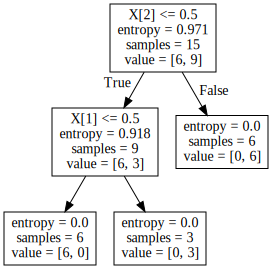

In [20]:
export_graphviz(clf, out_file = "sklearn_dt_tree.dot")
with open('sklearn_dt_tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

生成PDF文件

In [21]:
(graph, ) = pydot.graph_from_dot_file('sklearn_dt_tree.dot')
#需要根据实际安装目录，修改下面的文件
#需要修改文件E:\Anaconda3\envs\DXQ\Lib\site-packages\pydot.py
#第1712行：self.prog='dot.exe'
graph.write_pdf('sklearn_dt_tree.pdf')

使用鸢尾花数据集的所有数据进行训练和测试

In [22]:
from sklearn.model_selection import train_test_split

iris_npz = np.load('iris_full.npz')
data = iris_npz['data']
X = iris_npz['X']
Y = iris_npz['Y']

XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X, Y, test_size = 0.3)

In [23]:
clf = DecisionTreeClassifier(criterion = 'gini')
clf.fit(XTRAIN, YTRAIN)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [24]:
clf.score(XTEST, YTEST)

0.93333333333333335

绘制决策树

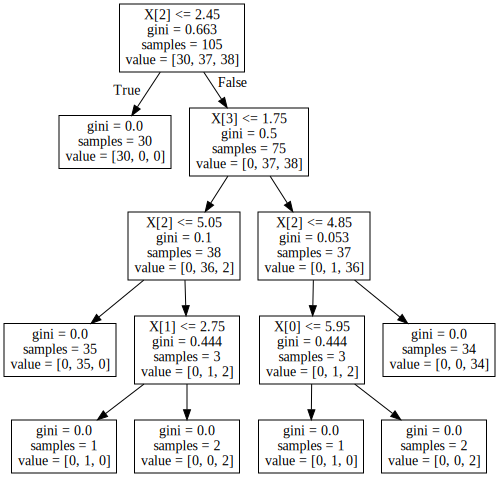

In [25]:
export_graphviz(clf, out_file = "sklearn_iris_dt_tree.dot")
with open('sklearn_iris_dt_tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

生成PDF文件

In [26]:
(graph, ) = pydot.graph_from_dot_file('sklearn_iris_dt_tree.dot')
graph.write_pdf('sklearn_iris_dt_tree.pdf')

参考文献
- https://github.com/wzyonggege/statistical-learning-method
- 《统计学习方法》第2版，李航；
- https://en.wikipedia.org/wiki/ID3_algorithm
- https://baike.baidu.com/item/ID3算法/5522381
- https://zh.wikipedia.org/wiki/条件熵
- https://zh.wikipedia.org/wiki/互信息